In [1]:
from diffusers.utils import load_image

import numpy as np


image = load_image("https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png")
numpy_array = np.array(image)

In [4]:
import dlib
detector = dlib.cnn_face_detection_model_v1('/home/aiteam/tykim/codeclone/freedom/pretrain_models/mmod_human_face_detector.dat')

In [5]:
sp = dlib.shape_predictor('./pretrain_models/shape_predictor_5_face_landmarks.dat')

In [6]:
dets = detector(numpy_array, 1)

In [7]:
len(dets) 

1

In [9]:
size_threshold=999

In [13]:
all_points = []
rec_list = []
for det in dets:
    if isinstance(detector, dlib.cnn_face_detection_model_v1):
        rec = det.rect # for cnn detector
    else:
        rec = det
    if rec.width() > size_threshold or rec.height() > size_threshold: 
        break
    rec_list.append(rec)
    shape = sp(numpy_array, rec) 
    single_points = []
    for i in range(5):
        single_points.append([shape.part(i).x, shape.part(i).y])
    all_points.append(np.array(single_points))

In [14]:
all_points

[array([[247, 196],
        [219, 193],
        [166, 178],
        [187, 185],
        [189, 247]])]

In [16]:
img_size = 256

In [17]:
out_size = (img_size, img_size)

In [18]:
template_path='./pretrain_models/FFHQ_template.npy'
template_scale=1
reference = np.load(template_path) / template_scale * (img_size / 256)

In [21]:
from skimage import transform as trans
from skimage import io


In [25]:
for idx, spoint in enumerate(all_points):
        tform = trans.SimilarityTransform()
        tform.estimate(spoint, reference)
        M = tform.params[0:2,:]

In [26]:
M

array([[   3.62951901,    0.88208298, -395.35319153],
       [  -0.88208298,    3.62951901,  -18.82521734]])

In [29]:
h, w = out_size[0], out_size[1]

In [32]:
import torch

In [33]:
a = torch.Tensor(
    [
        [2/(w-1), 0, -1],
        [0, 2/(h-1), -1],
        [0, 0, 1]
    ]
)
Mt = torch.Tensor(
    [  
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]
)
Mt[:2, :] = torch.Tensor(M)
Mt = torch.inverse(Mt)
h, w = 256, 256
b = torch.Tensor(
    [
        [2/(w-1), 0, -1],
        [0, 2/(h-1), -1],
        [0, 0, 1]
    ]
)
b = torch.inverse(b)
Mt = a.matmul(Mt)
Mt = Mt.matmul(b)[:2].unsqueeze(0)

In [45]:
Mt

tensor([[[ 0.2602, -0.0632, -0.0057],
         [ 0.0632,  0.2602, -0.4422]]])

In [38]:
import torch.nn.functional as F
grid = F.affine_grid(Mt, (1, 3, 512, 512), align_corners=True)

In [35]:
numpy_array = numpy_array.astype(np.float32)
    
# Transpose dimensions from [H, W, C] to [C, H, W]
numpy_array = numpy_array.transpose(2, 0, 1)

# Convert numpy array to pytorch tensor
tensor = torch.from_numpy(numpy_array)  

In [40]:
warp_D_x0_t = F.grid_sample(tensor.unsqueeze(0), grid, align_corners=True)

In [41]:
warp_D_x0_t.shape

torch.Size([1, 3, 512, 512])

In [42]:
import matplotlib.pyplot as plt

def visualize_tensor(tensor):
    # Ensure tensor is on CPU
    tensor = tensor.cpu()
    
    # Convert tensor to numpy array
    numpy_array = tensor.numpy()
    
    # Squeeze out the batch dimension and transpose dimensions from [3, 512, 512] to [512, 512, 3]
    numpy_array = np.squeeze(numpy_array).transpose(1, 2, 0)
    
    # Ensure the values are in the range [0, 1] for visualization
    numpy_array = np.clip(numpy_array, 0, 1)
    
    # Display the image
    plt.imshow(numpy_array)
    plt.axis('off')  # Hide axes
    plt.show()

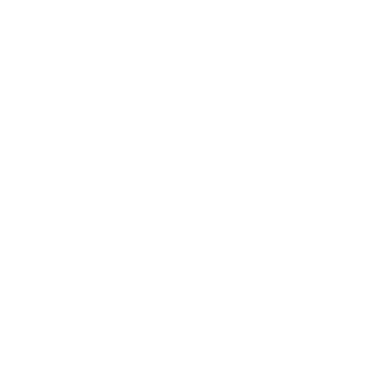

In [43]:
visualize_tensor(warp_D_x0_t)

In [46]:
from face_id_utils import get_tensor_M

In [57]:
M = get_tensor_M('/home/aiteam/tykim/codeclone/freedom/201903271203649127_2.jpg')

In [58]:
grid = F.affine_grid(M, (1, 3, 256, 256), align_corners=True)

In [60]:
# numpy_array = numpy_array.astype(np.float32)
# numpy_array = numpy_array.transpose(2, 0, 1)
# tensor = torch.from_numpy(numpy_array)

from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the image to 256x256
        transforms.ToTensor(),          # Convert image to tensor
    ])
    
# Load the image using PIL
image = Image.open('/home/aiteam/tykim/codeclone/freedom/201903271203649127_2.jpg').convert('RGB')  # Convert image to RGB format
tensor = transform(image)  # Apply the transformations

# Add batch dimension and replicate to match batch size
tensor = tensor.unsqueeze(0).repeat(1, 1, 1, 1)

In [62]:
warp_D_x0_t = F.grid_sample(tensor, grid, align_corners=True)

In [63]:
warp_D_x0_t.shape

torch.Size([1, 3, 256, 256])

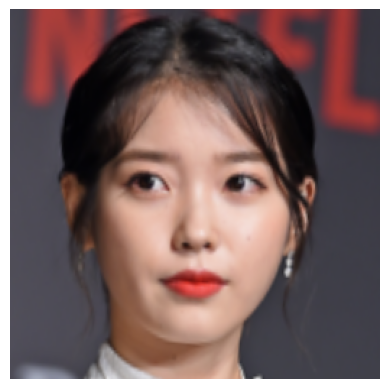

In [65]:
visualize_tensor(warp_D_x0_t)